Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. В рамках задачи предстоит составить палн работы и предложить рекомендации:

1. Загрузка и проверка данных
2. Предобработка данных, поиск дубликатов, пропусков исправление опечаток и регистров
3. Исследовательский анализ категориальных и количтсвенных данных, поиск и устранение аномалий. 
4. Обьединение данных в одну таблицу для анализа и модели
5. Кореляционный анализ количественных данных и устранени еколинеарности
6. Составленией пайплайна для анализа гиперпараметров и моделей лучше описывающих влияние признаков на вероятность уменьшение покупательной активности
7. Shape анализ влияния признаков на покупательную активность
8. Сегментация покупателей по выручке и вероятности уменьшения покупательной активности для выбора предложений
9. Общий вывод по работе

In [1]:
!pip install --upgrade scikit-learn
!pip install phik shap


  Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import FitFailedWarning

# Отключаем все предупреждения
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)

import shap
from tqdm import tqdm
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import RocCurveDisplay
from sklearn.cluster import KMeans
import os
from sklearn.inspection import permutation_importance

## 1.Загрузка данных

In [3]:
pth1 = '/datasets/market_file.csv'
pth2 = 'https://code.s3.yandex.net/datasets/market_file'
    
if os.path.exists(pth1):
    market_file = pd.read_csv(pth1)
elif os.path.exists(pth2):
    market_file = pd.read_csv(pth2)
else:
    print('Something is wrong')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В данных market_file содержится 1300 строк без пропусков. Типы данных соответствуют столбцам. Целесообразно проверить на дубликаты и исправить регистр

In [5]:
market_money=pd.read_csv('market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В данных market_money содержится 3900 строк без пропусков. Данные на одного пользователя представленны по месяцам. Связь с первой таблицей по id

In [7]:
market_time=pd.read_csv('market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В данных market_info представленна статистика  минутой на одного пользователя за два месяца текуший и предыдущий с явной опечаткой.

In [9]:
money=pd.read_csv('money.csv', sep=';', decimal=',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Вывод по разделу: В данных market_file содержится 1300 строк без пропусков. Типы данных соответствуют столбцам. Целесообразно проверить на дубликаты и исправить регистр.В данных market_money содержится 3900 строк без пропусков. Данные на одного пользователя представленны по месяцам.В данных market_info представленна статистика  минутой на одного пользователя за два месяца текуший и предыдущий с явной опечаткой.Датафрейм money пришлось открывать через разделитель sep=; и заменить запятую на точку в значении прибыль. В данных представленна статистика прибыли по каждому клиенту. Все датафремы связаны по id.


## 2.Предобработка данных

В данном разделе произведем проверку пропусков, поиск дубликатов и измение регистра столбцов с заменой опечатков.

## 2.1 market_fille

In [11]:
market_file.isnull().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Пропусков нет

In [12]:
duplicates = market_file.duplicated()
print(duplicates.sum())


0


явные дубликаты тоже отсутсвуют

Приведем значения строк типа object к нижнему регистру

In [13]:
text_cols = market_file.select_dtypes(include=['object']).columns
for col in text_cols:
    market_file[col] = market_file[col].str.strip().str.lower()
market_file.columns = market_file.columns.str.replace(' ', '_').str.lower()

In [14]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [15]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace({
    'стандартт': 'стандарт'  
})

In [16]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [17]:
market_file['покупательская_активность'].unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [18]:
market_file['популярная_категория'].unique()

array(['товары для детей', 'домашний текстиль', 'косметика и аксесуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

In [19]:
market_file['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [20]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


In [21]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

В данных market_file отсутсвуют дубликаты и пропуски. Произвден преход к змеиному регистру в названиях столбцов и данных типа object. Исправленна опечатка в столбце тип_сервиса стандартт на стандарт в остальных столбцах все впорядке

## 2.2 market_money

In [22]:
market_money.isnull().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [23]:
duplicates_money = market_money.duplicated()
print(duplicates_money.sum())

0


In [24]:
market_money.columns = market_money.columns.str.lower()

In [25]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [26]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [27]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В market_money нет пропусков, дубликатов и опечаток, только названия столбцов приведены к нижнеиу регистру

## 2.3 market_time

In [28]:
market_time.isnull().sum()

id        0
Период    0
минут     0
dtype: int64

In [29]:
duplicates_time = market_time.duplicated()
print(duplicates_time.sum())

0


In [30]:
market_time.columns = market_time.columns.str.lower()

In [31]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [32]:
market_time['период'] = market_time['период'].replace({
    'предыдцщий_месяц': 'предыдущий_месяц'  
})

In [33]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [34]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


В market_time нет пропусков и дубликатор, регистр столбцов замене на нижний и испарвленна опечатка в периодне на предыдущий месяц

## 2.4 money

In [35]:
money.isnull().sum()

id         0
Прибыль    0
dtype: int64

In [36]:
duplicates_money2 = money.duplicated()
print(duplicates_money2.sum())

0


In [37]:
money.columns = money.columns.str.lower()

In [38]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


В данных money нет пропусков и дубликатов только регистр столбцов заменен на нижний

Вывод по разделу:В данных market_file отсутсвуют дубликаты и пропуски. Произвден преход к змеиному регистру в названиях столбцов и данных типа object. Исправленна опечатка в столбце тип_сервиса стандартт на стандарт в остальных столбцах все впорядке.В market_money нет пропусков, дубликатов и опечаток, только названия столбцов приведены к нижнеиу регистру. В market_time нет пропусков и дубликатор, регистр столбцов замене на нижний и испарвленна опечатка в периодне на предыдущий месяц.В данных money нет пропусков и дубликатов только регистр столбцов заменен на нижний.

## 3.Исследовательский анализ данных

## 3.1 market_file

Для анализа возьмем функцию из предыдущего проекта


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
Категориальные признаки: ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.9,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.0,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.0,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.3,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.0,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.0,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.0,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.0,20.00


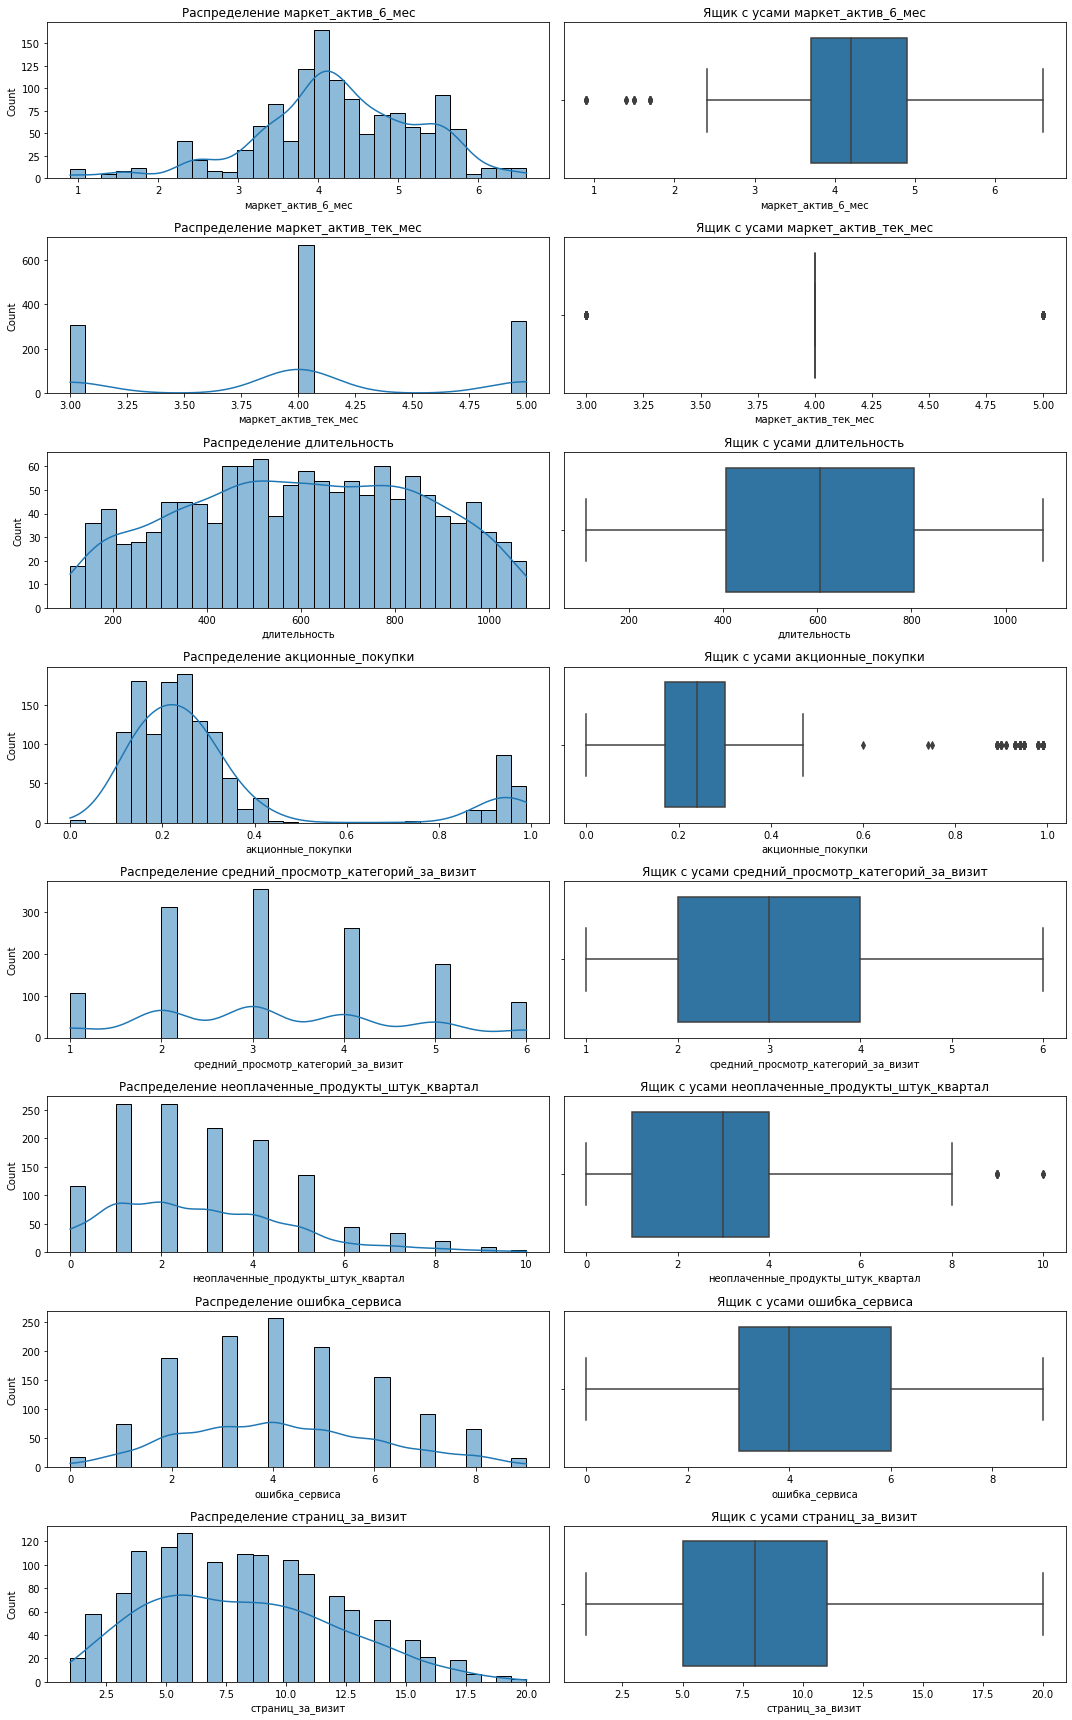


Выбросы (метод IQR):
маркет_актив_6_мес: 36 выбросов
маркет_актив_тек_мес: 631 выбросов
длительность: 0 выбросов
акционные_покупки: 168 выбросов
средний_просмотр_категорий_за_визит: 0 выбросов
неоплаченные_продукты_штук_квартал: 14 выбросов
ошибка_сервиса: 0 выбросов
страниц_за_визит: 0 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


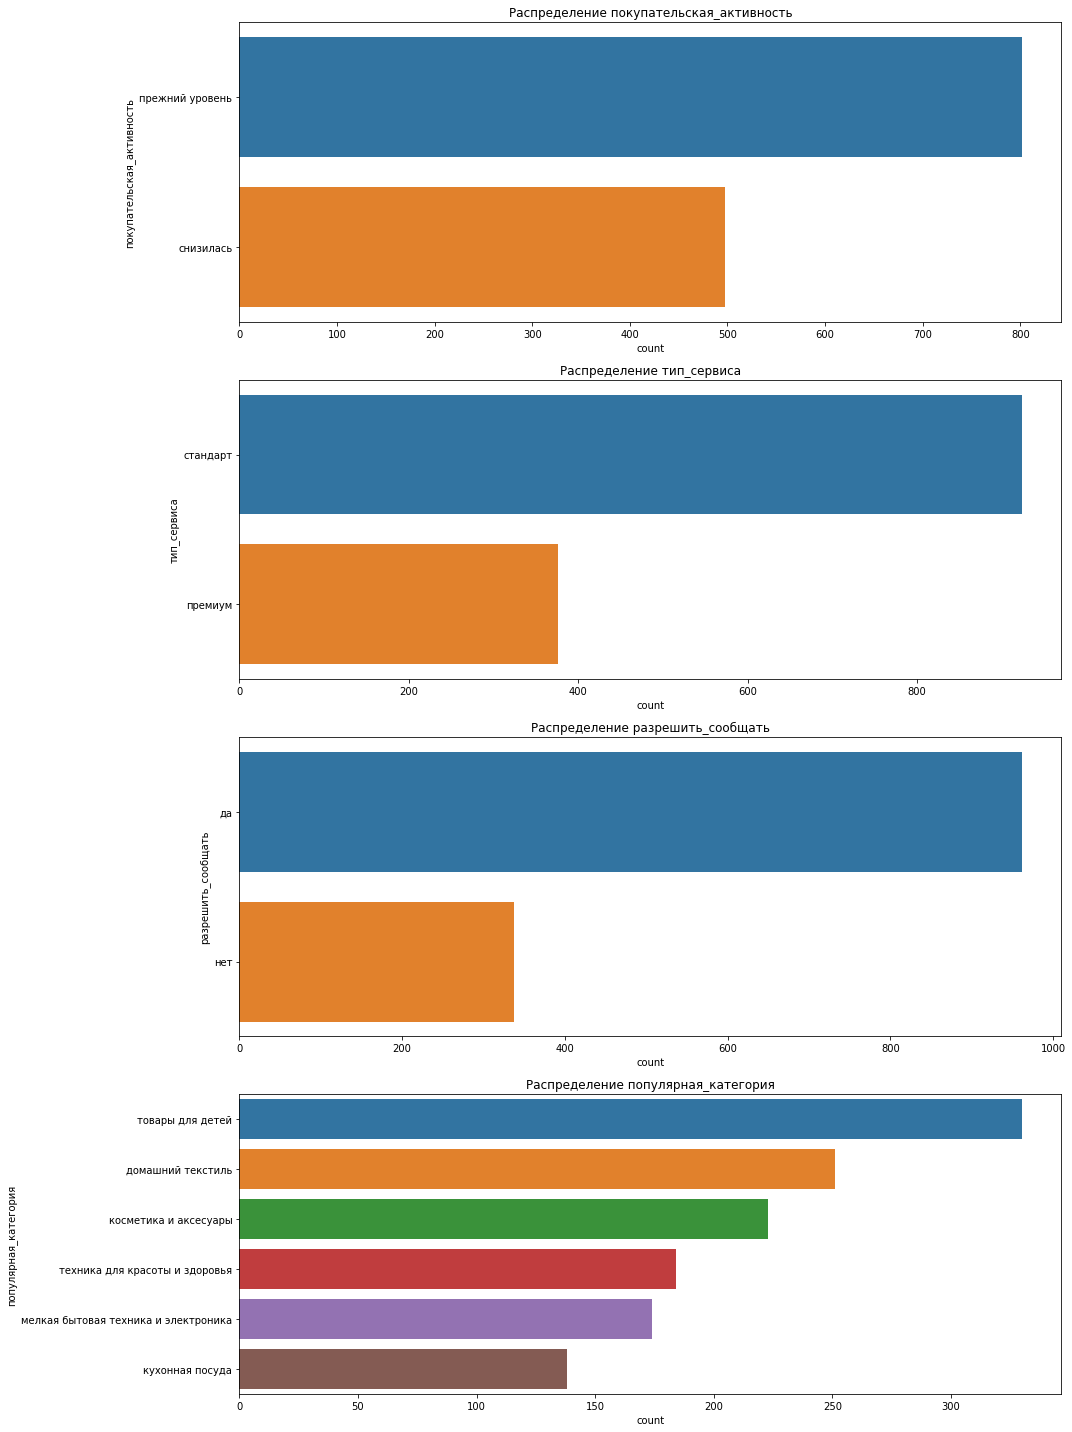

In [39]:
def analys(df):

    # 1. Разделение признаков на типы
    print("\n"+ "═"*50)
    print("1. Разделение признаков на типы")
    print("═"*50)
    df = df.drop(columns = ['id'], errors='ignore')
    numeric_cols = df.select_dtypes(include=['number']).columns 
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print("\nКоличественные признаки:", list(numeric_cols))
    print("Категориальные признаки:", list(categorical_cols))
    
    # 2. Статистический анализ количественных признаков
    print("\n"+ "═"*50)
    print("2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ")
    print("═"*50)
    
    # Описательная статистика
    print("\nОписательная статистика:")
    display(df[numeric_cols].describe().T)
    
    # Визуализация распределений
    plt.figure(figsize=(15, len(numeric_cols)*3))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 2, 2*i-1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Распределение {col}')
        
        plt.subplot(len(numeric_cols), 2, 2*i)
        sns.boxplot(x=df[col])
        plt.title(f'Ящик с усами {col}')
    plt.tight_layout()
    plt.show()
    
    # Проверка на выбросы
    print("\nВыбросы (метод IQR):")
    outliers = {}
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers[col] = outlier_count
        print(f"{col}: {outlier_count} выбросов")
    
    # 3. Анализ категориальных признаков
    print("\n"+ "═"*50)
    print("3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
    print("═"*50)
    
    plt.figure(figsize=(15, len(categorical_cols)*5))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(len(categorical_cols), 1, i)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Распределение {col}')
    plt.tight_layout()
    plt.show()
      
analys(market_file)

Выводы:1)Активность за 6 месяцев распределена со смением в прав в основном с больше 3,5 месяцев с наличием выбросов 1-2 месяца, что старанно так как длительность с момента регситрации больше 110 дней с медианой 600 или 10 месяцев. Видно что к 4 месяцу резко увеличилась актвиность интересно это акция или сезон праздников.
2) Активность за текуший месяц 3-5 
3) Длительность распределна нормально от 110 до 1089 дней 
4) Распределение акционных покупок интересное большая часть 0,15-0,35 и больше 0,85. Правое отклонение яшик с усами показывает как выбросы хотя это клиенты которые покупают только по акции, явно две категории клиентов 
5) В основном клиенты смотрят нескольок категорний 2-5
6) Число неоплаченых товаров  в корзине 1-4 что говорит о том чтотлюди добавляют в корзину то что хотят купить 
7) В среднем покупателя касается 4 сбоя сервиса а с большой вероятностью 3-6
8) За визит большая часть покупателей просматривают 5-11  страниц
9) почти у трети покупателей снизилась покупательная активность
10) колчиство покупателей с премиальным сервисом в 2,5 раза меньше чем сос тандартным
11) Три из черытрех покупателей разрешают сообщать платформе доп информацию о покупках
12) Самой покупательнйо категорией явлвяется товары для детей, домашний текстиль, косметика и аксессуары. Менее покупаемой является кохоная посуда, мелкая бытовая техника и электроника 

## 3.2 market_time


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['минут']
Категориальные признаки: ['период']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
минут,2600.0,13.336154,4.080198,4.0,10.0,13.0,16.0,23.0


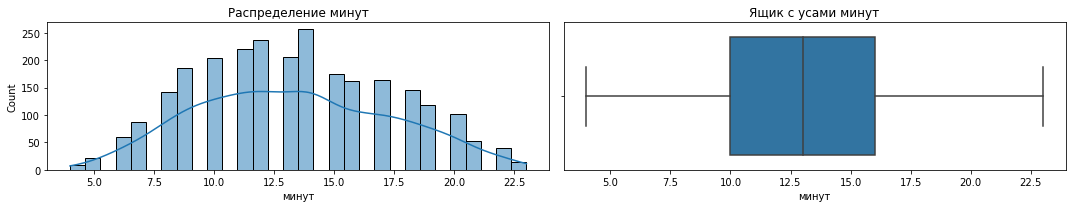


Выбросы (метод IQR):
минут: 0 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


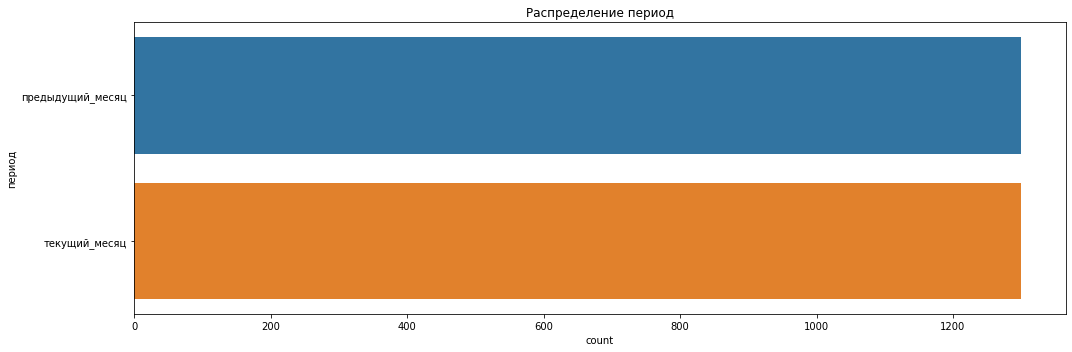

In [40]:
analys(market_time)

Выводы: В среднем покупатели проводят на сайте 13 минут в месяц. От 4 до 23. Текущий и предыдущий месяц представленны равномерно

## 3.3 Market_money


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['выручка']
Категориальные признаки: ['период']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.0,106862.2


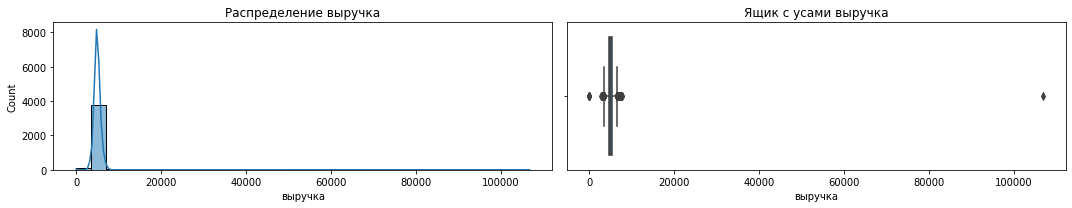


Выбросы (метод IQR):
выручка: 175 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


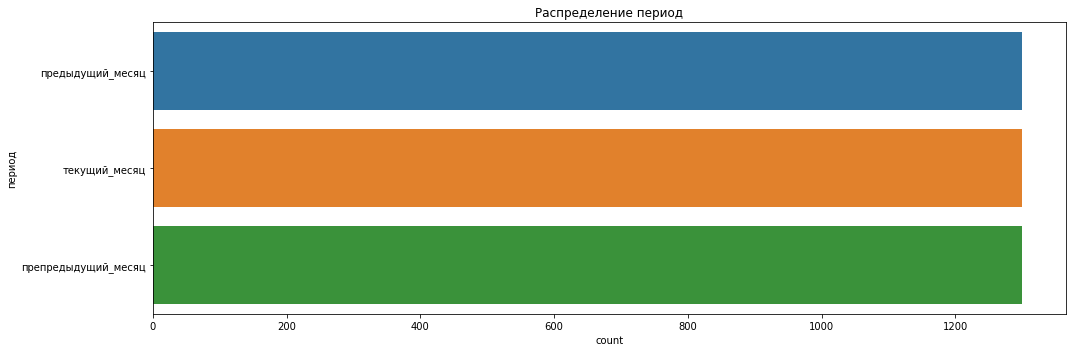

In [41]:
analys(market_money)

Средння выручка с клиента 5000. Большинство клиентов тратят от 1700 до 8000. присутствуют клиенты  с выручкой 106 тыс аномалия ли это? Я думаю да т.к. это одно значение которое уж сильно выбивается. Также есть клиенты с нулейвой выручкой но надо ли их не учитывать?


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['выручка']
Категориальные признаки: ['период']

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
выручка,3890.0,5007.541902,679.235737,2758.7,4592.0,4959.0,5363.0,7799.4


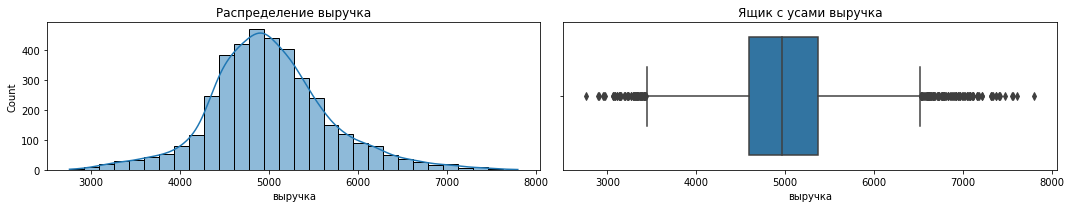


Выбросы (метод IQR):
выручка: 168 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


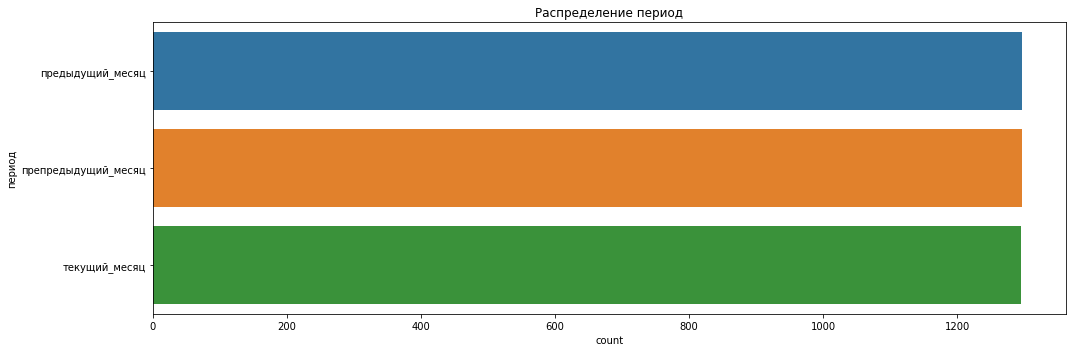

In [42]:
#Удалим выборосы
market_money_new = market_money[(market_money['выручка'] <= 20000)]
#Сгрупируем клиентов у которых есть пропуски в выручке в течении 3 месяцев
zero_revenue = market_money_new[
    (market_money_new['выручка'] == 0) & 
    (market_money_new['период'].isin(['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']))
]['id'].unique()
market_money_new = market_money_new[~market_money_new['id'].isin(zero_revenue)]

analys(market_money_new)

Средння выручка с клиента 5000 распределна номинально 2700 до 7800, с наличием выбросов которые явно надо учитывать. Впорос остался надо ли удалять пользователя без выручки

In [43]:
zero_revenue

array([215348, 215357, 215359])

## 3.4 Money


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['прибыль']
Категориальные признаки: []

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
прибыль,1300.0,3.996631,1.013722,0.86,3.3,4.045,4.67,7.43


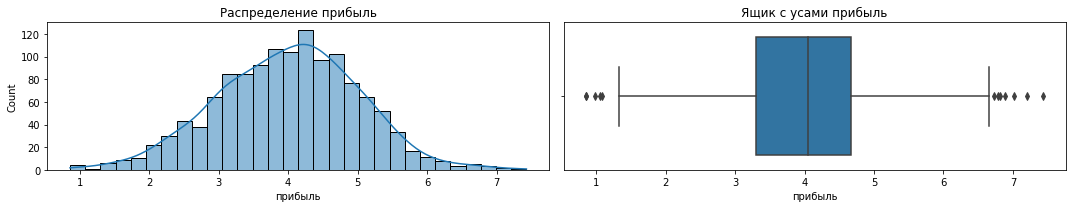


Выбросы (метод IQR):
прибыль: 12 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


<Figure size 1080x0 with 0 Axes>

In [44]:
analys(money)

Интересна кореляция выручки из market_money и прибыль в money они отличаются  в 1000 раз что явно косяк. Я так понимаю прибыль усреднена а выручка представленна за разные периоды. Интеренсо проверить по пользователям будет ли средння выручка равна прибыли 

In [45]:
average_revenue_by_period = market_money.groupby('id')['выручка'].mean().reset_index()
average_revenue_by_period.describe()

,id,выручка
count,1300.000000,1300.000000
mean,215997.500000,5025.696051
std,375.421985,1100.611825
min,215348.000000,1097.700000
25%,215672.750000,4647.650000
50%,215997.500000,5023.833333
75%,216322.250000,5362.341667
max,216647.000000,39330.066667


Ок впринципе да тогда надо прибыль умножить на 1000

In [46]:
money['прибыль'] = money['прибыль'] * 1000


══════════════════════════════════════════════════
1. Разделение признаков на типы
══════════════════════════════════════════════════

Количественные признаки: ['прибыль']
Категориальные признаки: []

══════════════════════════════════════════════════
2. АНАЛИЗ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
прибыль,1300.0,3996.630769,1013.722112,860.0,3300.0,4045.0,4670.0,7430.0


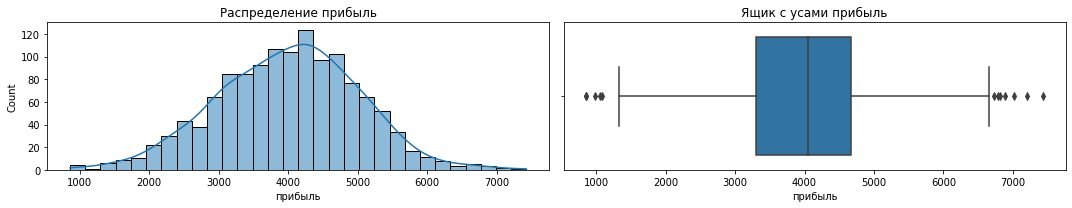


Выбросы (метод IQR):
прибыль: 12 выбросов

══════════════════════════════════════════════════
3. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
══════════════════════════════════════════════════


<Figure size 1080x0 with 0 Axes>

In [47]:
analys(money)

В среденем продавец получает выручку от одного покупателя 4000 что на 1000 меньше выручки видимо какието затраты учитывает

## 3.5 Учет клиентов с активностями за 3 месяца

In [48]:
valid_ids = market_money_new['id'].unique()

Нет ни одного клиента у которого удаляются три строки поэтому в датафрейме где только id нет смысла чтото трогать это market_file и money. Нужно только удалить эти строки по аналогичным периодам из market_time, получится должны удалить 4 строки за текущий и предыдущий месяцы. Удаление нужно провести по совпадению в столбцах id и период, для этого нашел два способа через merge и isin, аба через словарь 

In [49]:
market_file = market_file[market_file['id'].isin(valid_ids)]
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


In [50]:
market_time = market_time[market_time['id'].isin(valid_ids)]
market_time.describe()

,id,минут
count,2594.000000,2594.000000
mean,215998.986893,13.340401
std,374.506318,4.081999
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


Из данных market_money удаляются 10 строк а в market_time 6 строк текущий и педыдущий месяц

Вывод по разделу: market_file 1)Активность за 6 месяцев распределена со смещением в право в основном с больше 3,5 месяцев с наличием выбросов 1-2 месяца, что старанно так как длительность с момента регситрации больше 110 дней с медианой 600 или 10 месяцев. Видно что к 4 месяцу резко увеличилась актвиность интересно это акция или сезон праздников.
2) Активность за текуший месяц 3-5 
3) Длительность распределна нормально от 110 до 1089 дней 
4) Распределение акционных покупок интересное большая часть 0,15-0,35 и больше 0,85. Правое отклонение яшик с усами показывает как выбросы хотя это клиенты которые покупают только по акции, явно две категории клиентов 
5) В основном клиенты смотрят нескольок категорний 2-5
6) Число неоплаченых товаров  в корзине 1-4 что говорит о том чтотлюди добавляют в корзину то что хотят купить 
7) В среднем покупателя касается 4 сбоя сервиса а с большой вероятностью 3-6
8) За визит большая часть покупателей просматривают 5-11  страниц
9) почти у трети покупателей снизилась покупательная активность
10) колчиство покупателей с премиальным сервисом в 2,5 раза меньше чем сос тандартным
11) Три из черытрех покупателей разрешают сообщать платформе доп информацию о покупках
12) Самой покупательнйо категорией явлвяется товары для детей, домашний текстиль, косметика и аксессуары. Менее покупаемой является кохоная посуда, мелкая бытовая техника и электроника 
market_time В среднем покупатели проводят на сайте 13 минут в месяц. От 4 до 23. Текущий и предыдущий месяц представленны равномерно
market_money Средння выручка с клиента 5000 распределна номинально 2700 до 7800, с наличием выбросов которые явно надо учитывать. Впорос остался надо ли удалять пользователя без прибыли
money В среденем продавец получает выручку от одного покупателя 4000 что на 1000 меньше выручки видимо какието затраты учитывает
Клиенты с покупательнйо актитвностью в последнии 3 месяца учтены в money_new

## 4.Объединение таблиц

Как я понял задание нужно создать таблицу со строками уникальных id где данные по длительности (текущий месяц, предыдущий месяц) и выручке (препредыдущий, предыдущий и текущий) будут отдельным столбцами. Можно сделать как я а можно сделать 3893 строк при соответсвии периодов заполнялись выручка и длительность в остальных 0. Мне больше по душе 1 вариант для наглядности

In [51]:
time = market_time.pivot(
    index='id',         # Строки по id
    columns='период',   # Столбцы по периодам
    values='минут'    # Значения - минут
).reset_index()

# Переименовываем столбцы для ясности
time.columns = ['id', 'минут_предыдущий', 'минут_текущий']
market_file_time = pd.merge(
    market_file,
    time,
    on='id',  # Общий ключ
    how='right'  # Сохраняем все строки из market_time
)
market_file_time.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий,минут_текущий
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,13.469545,13.211257
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,3.936323,4.220222
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,11.000000,10.000000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,13.000000,13.000000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,17.000000,16.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,23.000000,23.000000


In [52]:
market_file_time.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий,минут_текущий
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,10,10


In [53]:
money_wide = market_money_new.pivot(
    index='id',         # Строки по id
    columns='период',   # Столбцы по периодам
    values='выручка'    # Значения - выручка
).reset_index()

# Переименовываем столбцы для ясности
money_wide.columns = ['id', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']
market_all = pd.merge(
    market_file_time,
    money_wide,
    on='id',
    how='left'
)
market_all.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий,минут_текущий,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1296.000000
mean,215998.986893,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584,13.469545,13.211257,4948.339630,4836.367772,5238.096065
std,374.578554,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061,3.936323,4.220222,701.228571,333.438742,834.318717
min,215349.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000,5.000000,4.000000,2890.000000,4098.000000,2758.700000
25%,215675.000000,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000,11.000000,10.000000,4498.500000,4585.000000,4706.050000
50%,215999.000000,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000,13.000000,13.000000,5005.500000,4812.000000,5179.950000
75%,216323.000000,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000,17.000000,16.000000,5409.000000,5055.000000,5759.275000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000,23.000000,23.000000,6869.500000,5663.000000,7799.400000


In [54]:
market_all.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий,минут_текущий,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5
5,215354,снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксесуары,2,3,7,2,11,12,5685.0,4503.0,5869.6
6,215355,снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,12,10,3263.0,4749.0,3772.6
7,215356,снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,2,2,1,3,6,7,4146.5,4433.0,4566.4
8,215358,снизилась,стандарт,да,4.7,4,450,0.13,домашний текстиль,4,2,6,4,14,10,3488.0,4727.0,4209.5
9,215360,снизилась,премиум,да,3.9,3,623,0.35,кухонная посуда,3,1,4,7,9,6,5304.5,5555.0,5834.9


In [55]:
market_all.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минут_предыдущий                       0
минут_текущий                          0
выручка_препредыдущий                  0
выручка_предыдущий                     0
выручка_текущий                        1
dtype: int64

Логично что те 4 строчки которые мы удалили превратиль в пропуски nan от которых нужно избавиться

In [57]:
market_all.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минут_предыдущий                       0
минут_текущий                          0
выручка_препредыдущий                  0
выручка_предыдущий                     0
выручка_текущий                        1
dtype: int64

In [58]:
market_all['выручка_текущий'] = market_all.groupby('id')['выручка_текущий'].fillna(market_all['выручка_предыдущий'])

In [59]:
market_all.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минут_предыдущий                       0
минут_текущий                          0
выручка_препредыдущий                  0
выручка_предыдущий                     0
выручка_текущий                        0
dtype: int64

In [60]:
market_all.head(20)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий,минут_текущий,выручка_препредыдущий,выручка_предыдущий,выручка_текущий
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5
5,215354,снизилась,стандарт,да,5.1,3,431,0.23,косметика и аксесуары,2,3,7,2,11,12,5685.0,4503.0,5869.6
6,215355,снизилась,стандарт,нет,4.7,4,284,0.17,товары для детей,5,1,6,4,12,10,3263.0,4749.0,3772.6
7,215356,снизилась,стандарт,да,4.2,4,192,0.14,косметика и аксесуары,2,2,1,3,6,7,4146.5,4433.0,4566.4
8,215358,снизилась,стандарт,да,4.7,4,450,0.13,домашний текстиль,4,2,6,4,14,10,3488.0,4727.0,4209.5
9,215360,снизилась,премиум,да,3.9,3,623,0.35,кухонная посуда,3,1,4,7,9,6,5304.5,5555.0,5834.9


Вывод по разделу: В данном разделе был произведено обьединение треж тадблиц market_file, market_money, market_time в одну таблицу market_all. Во всех таблицах одинаковый столбец id однако разные периоды в money_time два месяца пердыдущий и текущий, в market_money три периодна предыдущий, предыдущий. Для обьединения в исходный датафрейм market_file дыли добавлены данные расчета сводных таблиц по периодам в виде отдельных столбцов минут_текущий,минут_предыдущий, выручка_препредыдущий, выручка_предыдущий, выручка_текущий. 

Вопрос правильно ли заменить пропуски на медиану или лучше 0 или заглушками?

## 5. Корреляционный анализ

Для оценки кореляции выделим коллчисетвенные переменные


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минут_предыдущий', 'минут_текущий', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']


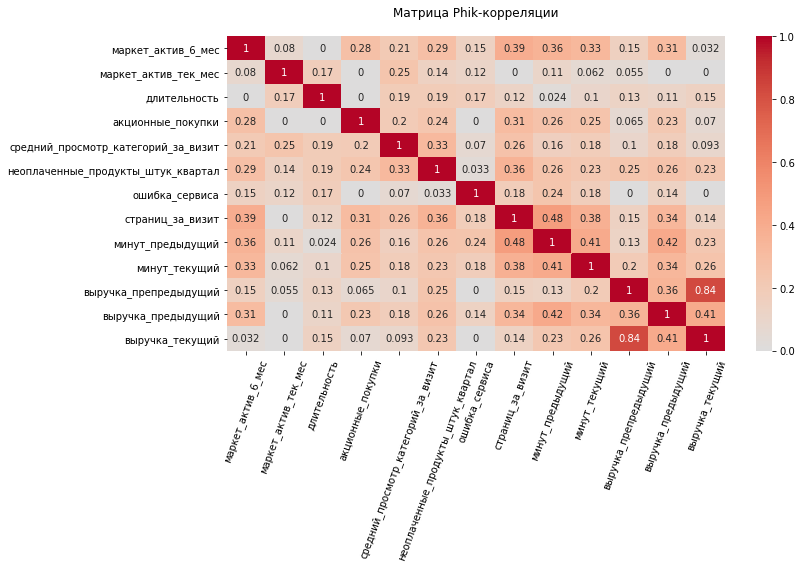

In [63]:
quant_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'минут_предыдущий', 'минут_текущий', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий'
]
quant_data = market_all[quant_cols]

plt.figure(figsize=(12, 8))
corr_matrix = quant_data.phik_matrix()  # Используем Phik-корреляцию
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=0, vmax=1)
plt.title("Матрица Phik-корреляции", pad=20)
plt.xticks(rotation=70)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

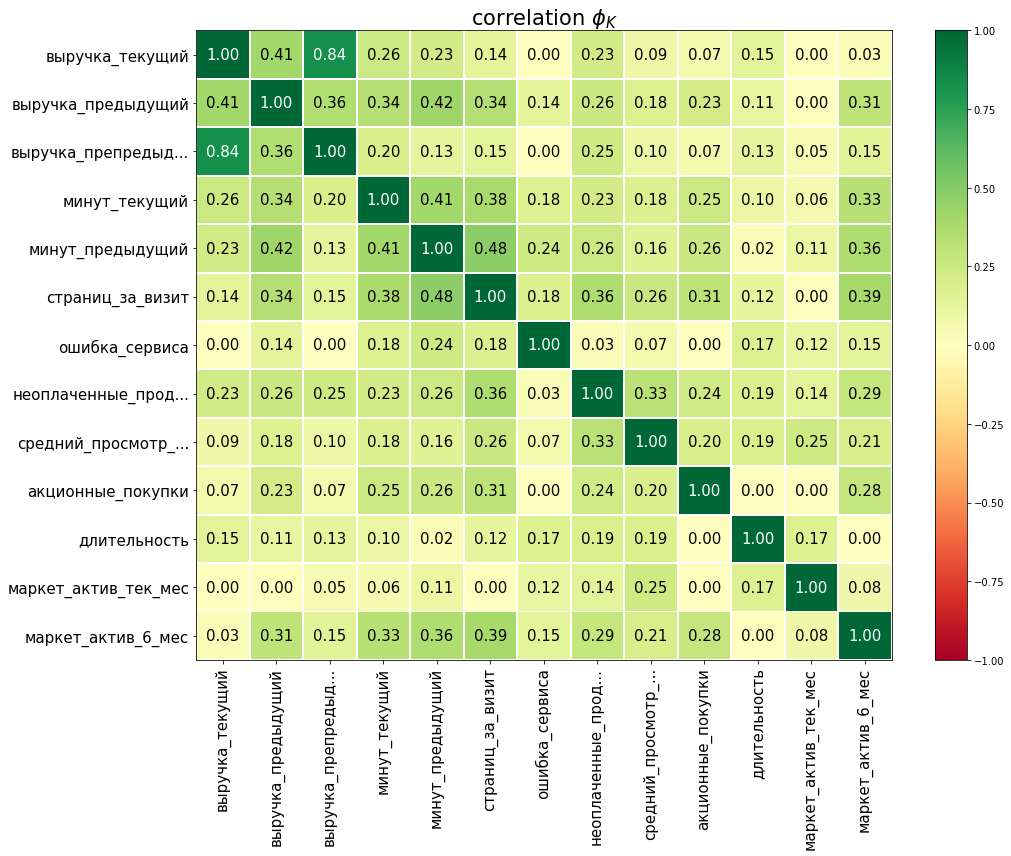

In [64]:
# список интервальных признаков
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
    'акционные_покупки', 'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'минут_предыдущий', 'минут_текущий', 'выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий'
]


# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = market_all[interval_cols].phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Вывод по разделу: Сильной корреляции а также мультилоинеарности не было замечено. Есть кореляция между длительностью в мин и сраниц за визит, что логично и маркет автивностью за 6 месяцев и страниц за визит, длительностью что тоже вполне логично. Хотя по идее должна быть серьезная колинеарность между выручками,минутами, маркет_активностями в разные периодны.

## 6. Использование пайплайнов

 В качестве метрики лучше использовать f1 score так она является сбалансориванной метриковй для категориального предсказания между precission и racal. В качестве гиперпараметров использовал диапазоны из теории не стал сильно увеличивать range чтобы не ждать вечность.

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [65]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
SCORING = 'roc_auc'

# Загрузка данных (предполагаем, что данные уже загружены)
# data = pd.read_csv('market_data.csv')

# Подготовка данных
X = market_all.drop(['покупательская_активность', 'id'], axis=1)
y = market_all['покупательская_активность']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Списки признаков
num_cols = [
    'маркет_актив_тек_мес', 'маркет_актив_6_мес', 'длительность', 
    'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 'страниц_за_визит', 'средний_просмотр_категорий_за_визит',
    'минут_предыдущий', 'минут_текущий', 'выручка_препредыдущий', 
    'выручка_предыдущий', 'выручка_текущий'
]

binary_cols = ['тип_сервиса']  # Бинарный признак
other_cat_cols = ['разрешить_сообщать', 'популярная_категория']  # Остальные категориальные

In [66]:
class_ratio = market_all['покупательская_активность'].value_counts(normalize=True)
class_ratio

прежний уровень    0.61835
снизилась          0.38165
Name: покупательская_активность, dtype: float64


=== Обучение и оценка модели LogisticRegression ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV ROC-AUC (mean): 0.8984 ± 0.0211
Test ROC-AUC: 0.9230
Разница (CV-Test): -0.0246
Лучшие параметры: {'preprocessor__other_cat__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__num__scaler': RobustScaler(), 'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 1}

=== Обучение и оценка модели DecisionTree ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV ROC-AUC (mean): 0.8644 ± 0.0152
Test ROC-AUC: 0.8616
Разница (CV-Test): 0.0028
Лучшие параметры: {'preprocessor__other_cat__encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 'preprocessor__num__scaler': StandardScaler(), 'model__min_samples_split': 7, 'model__max_depth': 5}

=== Обучение и оценка модели SVC ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
CV ROC-AUC (mean): 0.9148 ± 0.0176
Test ROC-AUC: 0.9211
Разница (CV

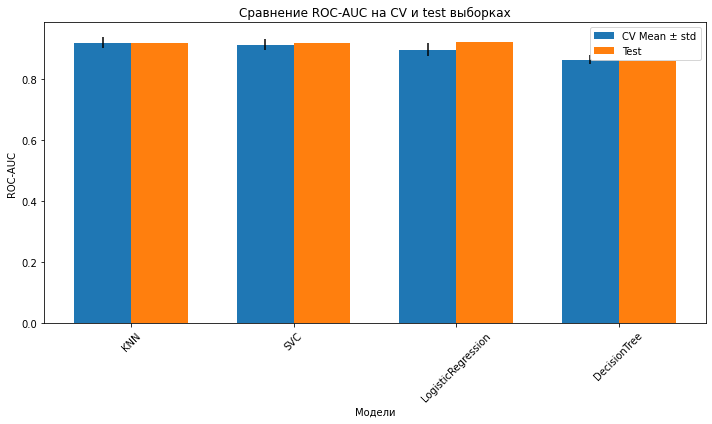


Итоговые результаты всех моделей:


,model,cv_roc_auc,cv_std,test_roc_auc,overfitting_gap
3,KNN,0.921272,0.018785,0.919616,0.001656
2,SVC,0.914806,0.017595,0.921080,-0.006274
0,LogisticRegression,0.898380,0.021126,0.923006,-0.024626
1,DecisionTree,0.864434,0.015204,0.861619,0.002814



Анализ переобучения:
Наибольший разрыв (переобучение): 0.0028 (DecisionTree)
Наименьший разрыв: -0.0246 (LogisticRegression)


<Figure size 720x576 with 0 Axes>

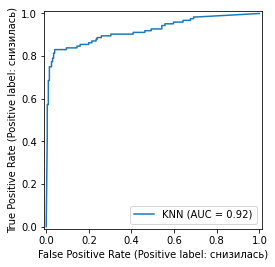

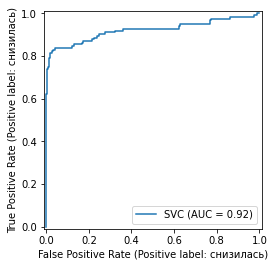

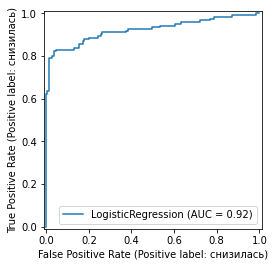

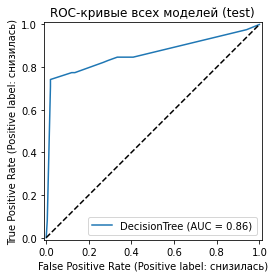


Лучшая модель: KNN
CV ROC-AUC: 0.9213 ± 0.0188
Test ROC-AUC: 0.9196
Лучшие параметры: {'preprocessor__other_cat__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__num__scaler': RobustScaler(), 'model__weights': 'distance', 'model__n_neighbors': 12}


In [67]:
preprocessor = ColumnTransformer([
    # Числовые признаки (2 скалера)
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())  # Будем перебирать
    ]), num_cols),
    
    # Бинарные признаки (всегда OHE с drop)
    ('binary_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), binary_cols),
    
    # Остальные категориальные (2 энкодера)
    ('other_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Будем перебирать
    ]), other_cat_cols)
])

# Модели с обновленными параметрами
models = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
            'preprocessor__other_cat__encoder': [
                OneHotEncoder(handle_unknown='ignore', drop='first'),
            ],
            'model__C': range(1, 7),
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear', 'saga']
        }
    },
    {
        'name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
            'preprocessor__other_cat__encoder': [
                OneHotEncoder(handle_unknown='ignore', drop='first'),
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            ],
            'model__max_depth': range(1, 7),
            'model__min_samples_split': range(2, 8)
        }
    },
    {
        'name': 'SVC',
        'model': SVC(random_state=RANDOM_STATE, probability=True),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
            'preprocessor__other_cat__encoder': [
                OneHotEncoder(handle_unknown='ignore', drop='first'),
            ],
            'model__C': range(1, 7),
            'model__kernel': ['linear', 'rbf']
        }
    },
    {
        'name': 'KNN',
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler()],
            'preprocessor__other_cat__encoder': [
                OneHotEncoder(handle_unknown='ignore', drop='first'),
            ],
            'model__n_neighbors': range(3, 15),
            'model__weights': ['uniform', 'distance']
        }
    }
]

# Обучение с ROC-AUC
final_results = []

for model_info in models:
    print(f"\n=== Обучение и оценка модели {model_info['name']} ===")
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    search = RandomizedSearchCV(
        pipe,
        model_info['params'],
        cv=5,
        scoring=SCORING,
        n_iter=20,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train)
    
    # Предсказания только для тестовой выборки
    y_test_pred_proba = search.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    # Сохраняем результаты
    final_results.append({
        'model': model_info['name'],
        'best_params': search.best_params_,
        'cv_roc_auc': search.best_score_,  # Средний ROC-AUC по кросс-валидации
        'test_roc_auc': test_roc_auc,      # ROC-AUC на тестовой выборке
        'overfitting_gap': search.best_score_ - test_roc_auc,
        'best_estimator': search.best_estimator_,
        'cv_std': search.cv_results_['std_test_score'][search.best_index_]  # Стандартное отклонение
    })
    
    # Вывод результатов для текущей модели
    print(f"CV ROC-AUC (mean): {search.best_score_:.4f} ± {final_results[-1]['cv_std']:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Разница (CV-Test): {final_results[-1]['overfitting_gap']:.4f}")
    print("Лучшие параметры:", search.best_params_)
    print("="*50)

# Создаем DataFrame для анализа
results_df = pd.DataFrame(final_results)

# Сортируем по кросс-валидационной оценке (не по тестовой!)
results_df = results_df.sort_values('cv_roc_auc', ascending=False)

# Визуализация сравнения метрик
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_df))

plt.bar(index, results_df['cv_roc_auc'], bar_width, 
        yerr=results_df['cv_std'], 
        label='CV Mean ± std')
plt.bar(index + bar_width, results_df['test_roc_auc'], 
        bar_width, label='Test')

plt.xlabel('Модели')
plt.ylabel('ROC-AUC')
plt.title('Сравнение ROC-AUC на CV и test выборках')
plt.xticks(index + bar_width/2, results_df['model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Вывод таблицы с результатами
print("\nИтоговые результаты всех моделей:")
display(results_df[['model', 'cv_roc_auc', 'cv_std', 'test_roc_auc', 'overfitting_gap']])

# Анализ переобучения
print("\nАнализ переобучения:")
print(f"Наибольший разрыв (переобучение): {results_df['overfitting_gap'].max():.4f} ({results_df.loc[results_df['overfitting_gap'].idxmax(), 'model']})")
print(f"Наименьший разрыв: {results_df['overfitting_gap'].min():.4f} ({results_df.loc[results_df['overfitting_gap'].idxmin(), 'model']})")

# ROC-кривые для всех моделей на тестовых данных
plt.figure(figsize=(10, 8))
for i, row in results_df.iterrows():
    RocCurveDisplay.from_estimator(row['best_estimator'], X_test, y_test, name=row['model'])
plt.title('ROC-кривые всех моделей (test)')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Выбор лучшей модели по кросс-валидации
best_model_info = results_df.iloc[0]
print(f"\nЛучшая модель: {best_model_info['model']}")
print(f"CV ROC-AUC: {best_model_info['cv_roc_auc']:.4f} ± {best_model_info['cv_std']:.4f}")
print(f"Test ROC-AUC: {best_model_info['test_roc_auc']:.4f}")
print("Лучшие параметры:", best_model_info['best_params'])


Вывод по разделу: В качестве метрики лучше использовать roc_auc . Лучший 0.9213 показала себя модель KNN регрессии с обработкой OnehotEncoder для категориальных признаков, RobustScaler для количественных признаков с количеством соседей 12

## 7. Анализ важности признаков


Лучшая модель: KNN с ROC-AUC = 0.9196
Применяем Permutation Importance для KNN...


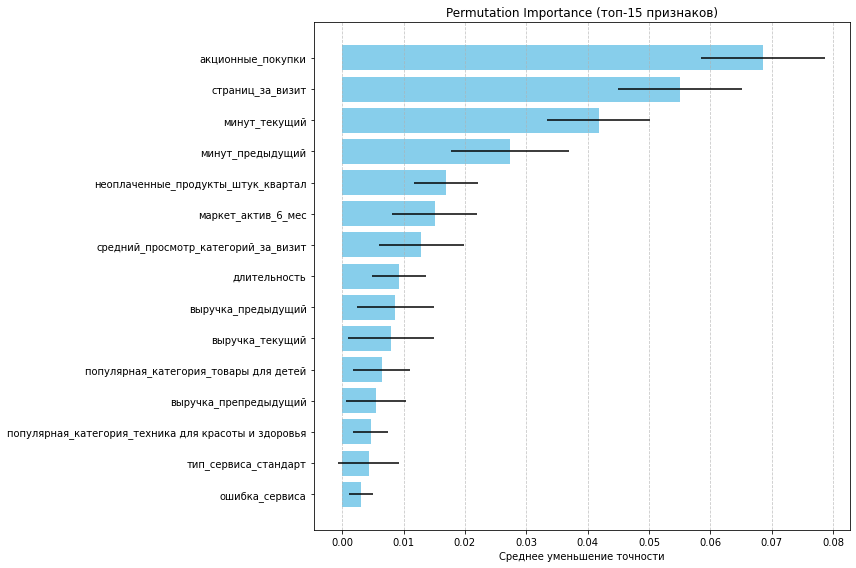


Топ-10 самых важных признаков:


,Признак,Важность,Стандартное отклонение
0,акционные_покупки,0.068615,0.010116
1,страниц_за_визит,0.055077,0.010154
2,минут_текущий,0.041846,0.008393
3,минут_предыдущий,0.027385,0.009578
4,неоплаченные_продукты_штук_квартал,0.016923,0.005194
5,маркет_актив_6_мес,0.015077,0.006942
6,средний_просмотр_категорий_за_визит,0.012923,0.006989
7,длительность,0.009231,0.004351
8,выручка_предыдущий,0.008615,0.006276
9,выручка_текущий,0.008000,0.007043


In [68]:
# Выбираем лучшую модель
best_model_info = results_df.iloc[0]
best_model = best_model_info['best_estimator']
print(f"\nЛучшая модель: {best_model_info['model']} с ROC-AUC = {best_model_info['test_roc_auc']:.4f}")

# Для KNN используем только Permutation Importance - это более надежный метод
if best_model_info['model'] == 'KNN':
    print("Применяем Permutation Importance для KNN...")
    
    # Получаем препроцессор и модель
    preprocessor = best_model.named_steps['preprocessor']
    model = best_model.named_steps['model']
    
    # Преобразуем тестовые данные
    X_test_transformed = preprocessor.transform(X_test)
    
    # Получаем имена признаков после преобразования
    feature_names = []
    feature_names.extend(num_cols)  # Числовые признаки
    
    if 'binary_cat' in preprocessor.named_transformers_:
        binary_encoder = preprocessor.named_transformers_['binary_cat'].named_steps['encoder']
        feature_names.extend(binary_encoder.get_feature_names_out(binary_cols))
    
    if 'other_cat' in preprocessor.named_transformers_:
        cat_encoder = preprocessor.named_transformers_['other_cat'].named_steps['encoder']
        feature_names.extend(cat_encoder.get_feature_names_out(other_cat_cols))
    
    # Вычисляем важность признаков
    result = permutation_importance(
        model,
        X_test_transformed,
        y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Сортируем признаки по важности
    sorted_idx = result.importances_mean.argsort()[::-1]
    
    # Визуализация (топ-15 признаков)
    plt.figure(figsize=(12, 8))
    plt.barh(
        np.array(feature_names)[sorted_idx][:15],  # Только топ-15 признаков
        result.importances_mean[sorted_idx][:15],
        xerr=result.importances_std[sorted_idx][:15],
        color='skyblue'
    )
    plt.xlabel('Среднее уменьшение точности')
    plt.title('Permutation Importance (топ-15 признаков)')
    plt.gca().invert_yaxis()  # Самые важные признаки сверху
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Таблица с результатами
    importance_df = pd.DataFrame({
        'Признак': np.array(feature_names)[sorted_idx],
        'Важность': result.importances_mean[sorted_idx],
        'Стандартное отклонение': result.importances_std[sorted_idx]
    })
    
    print("\nТоп-10 самых важных признаков:")
    display(importance_df.head(15))

# Для других моделей (DecisionTree, LogisticRegression) оставляем SHAP
else:
    print(f"Применяем SHAP для {best_model_info['model']}...")
    
    preprocessor = best_model.named_steps['preprocessor']
    model = best_model.named_steps['model']
    X_train_transformed = preprocessor.transform(X_train)
    
    # Получаем имена признаков
    feature_names = []
    feature_names.extend(num_cols)
    
    if 'binary_cat' in preprocessor.named_transformers_:
        binary_encoder = preprocessor.named_transformers_['binary_cat'].named_steps['encoder']
        feature_names.extend(binary_encoder.get_feature_names_out(binary_cols))
    
    if 'other_cat' in preprocessor.named_transformers_:
        cat_encoder = preprocessor.named_transformers_['other_cat'].named_steps['encoder']
        feature_names.extend(cat_encoder.get_feature_names_out(other_cat_cols))
    
    if best_model_info['model'] == 'DecisionTree':
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train_transformed)
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train_transformed, 
                         feature_names=feature_names, plot_type="bar")
        plt.title(f"SHAP Feature Importance - {best_model_info['model']}")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train_transformed, 
                         feature_names=feature_names)
        plt.title(f"SHAP Values - {best_model_info['model']}")
        plt.tight_layout()
        plt.show()
    
    elif best_model_info['model'] == 'LogisticRegression':
        explainer = shap.LinearExplainer(model, X_train_transformed, 
                                      feature_dependence="independent")
        shap_values = explainer.shap_values(X_train_transformed)
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train_transformed, 
                         feature_names=feature_names, plot_type="bar")
        plt.title(f"SHAP Feature Importance - {best_model_info['model']}")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train_transformed, 
                         feature_names=feature_names)
        plt.title(f"SHAP Values - {best_model_info['model']}")
        plt.tight_layout()
        plt.show()

Из Shap анализа можно сделать выводы:
1) Признаки которые наимеенее влияют на целевой признак выручка за текущий и препредыдущий месяцы, тип сервиса, маркет актив_тек_месяц
2) наиболее влиятельные признаки посещение страниц за визит, акционные опкупки, средний просмотр категорий за визит, длительность посещения минут в предыдущий месяц, маркет активность за 6 месяцев
3) Признаки которые увеличивают вероятнорсть уменьшения покупательнйо аквтиности это признаки с высоким значение справа а это акционные покупки и неоплаченные продукты.
4)Для задачи важны признаки которые уменьшают вероятность снижения активности это кол страниц за визит, средний просмотр категорий длительность мин за предыдущий период, макркет актвиность за 6 месяцев влияют на уменьшение активности  цель повышать эти признаки

</span><br><span style="color: purple; font-weight: bold">Вывод </span> 1) Признаки которые имеют наибольшее влияние на целевой показаетль количество акционых покупок, страниц за визит, минут проведеных на платформе 2) Признаки которые имеют наименьшее влияние на целевой ошибка сервиса, тип сервиса,популярная категория,выручка

## 8.Сегментация покупателей

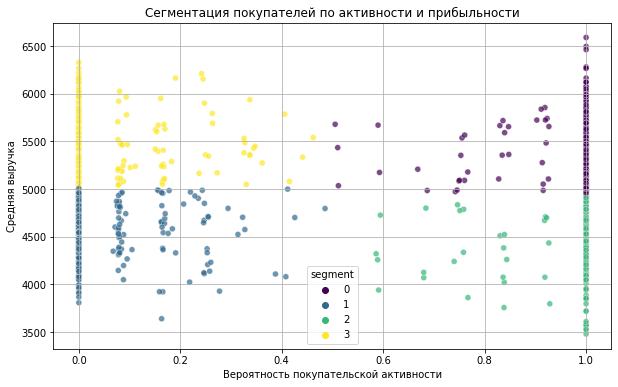

        prob_activity            avg_revenue             count
                 mean       std         mean         std count
segment                                                       
0            0.973745  0.083038  5409.894769  330.622886   274
1            0.036396  0.083049  4609.466500  282.801608   400
2            0.973100  0.081923  4459.669352  354.419373   211
3            0.030071  0.081900  5407.059061  291.781728   412


In [69]:
# 1. Получаем предсказания модели
market_all['prob_activity'] = best_model.predict_proba(X)[:, 1]  # вероятность активности

# 2. Добавляем прибыльность (пример: средняя выручка за 3 месяца)
market_all['avg_revenue'] = market_all[['выручка_препредыдущий', 'выручка_предыдущий', 'выручка_текущий']].mean(axis=1)

# 3. Масштабируем данные для кластеризации
scaler = StandardScaler()
scaled_data = scaler.fit_transform(market_all[['prob_activity', 'avg_revenue']])

# 4. Кластеризация K-Means (4 сегмента)
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
market_all['segment'] = kmeans.fit_predict(scaled_data)

# 5. Визуализация сегментов
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=market_all,
    x='prob_activity',
    y='avg_revenue',
    hue='segment',
    palette='viridis',
    alpha=0.7
)
plt.title('Сегментация покупателей по активности и прибыльности')
plt.xlabel('Вероятность покупательской активности')
plt.ylabel('Средняя выручка')
plt.grid(True)
plt.show()

# 6. Описание сегментов
segment_stats = market_all.groupby('segment').agg({
    'prob_activity': ['mean', 'std'],
    'avg_revenue': ['mean', 'std'],
    'id': 'count'
}).rename(columns={'id': 'count'})

print(segment_stats)

C точки зрения бизнеса нам интересно поднять выручку сегмента 3 и уменьшить вериятность снижения покупательской активности сегоментов 0 и 2

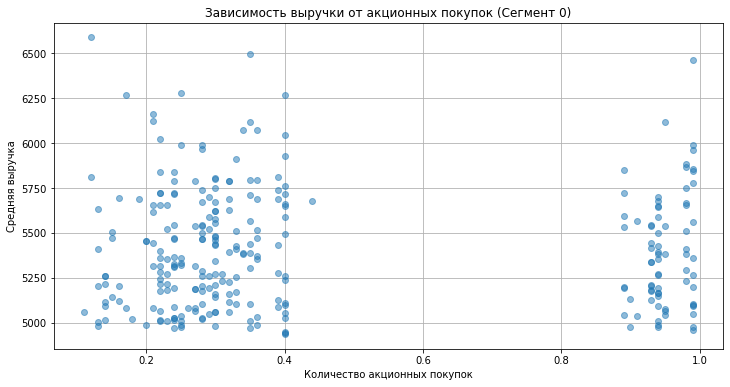

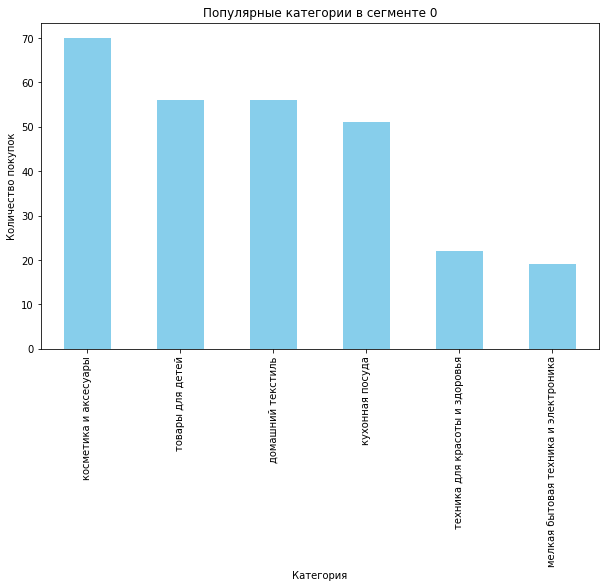

In [70]:
segment_0 = market_all[market_all['segment'] == 0]

# Зависимость выручки от акционных покупок (линейный график)
plt.figure(figsize=(12, 6))
plt.plot(segment_0['акционные_покупки'], segment_0['avg_revenue'], 'o', alpha=0.5)
plt.title('Зависимость выручки от акционных покупок (Сегмент 0)')
plt.xlabel('Количество акционных покупок')
plt.ylabel('Средняя выручка')
plt.grid(True)
plt.show()

# Распределение по популярным категориям (обычный bar plot)
plt.figure(figsize=(10, 6))
segment_0['популярная_категория'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Популярные категории в сегменте 0')
plt.xlabel('Категория')
plt.ylabel('Количество покупок')
plt.show()

Сегмент 0 является самым важным в текущей задачи это люди с высокой выручкой и высокой вероятность уменьшения активности именно на них нужно ориентироваться, особенность этой категории что тут либо берут почти все товары по акции либо наооборот нет середины в таком сегменте нужно настраивать фильтры и предлагать им товары с разных категорий по акции и без чтобы увеличить время их пребывания и коллчиство просматриваемых категорий которые уменьшают риск снижения активности

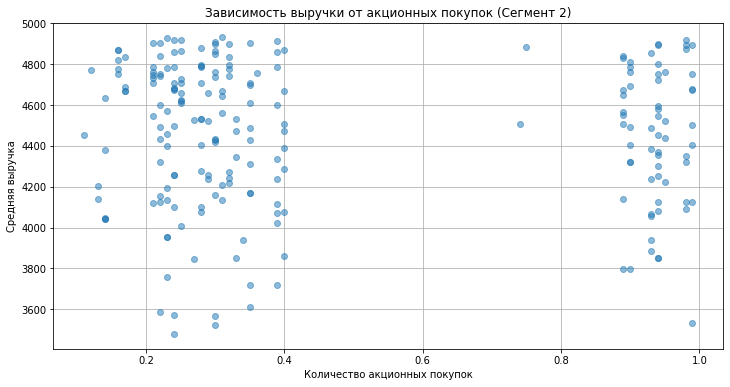

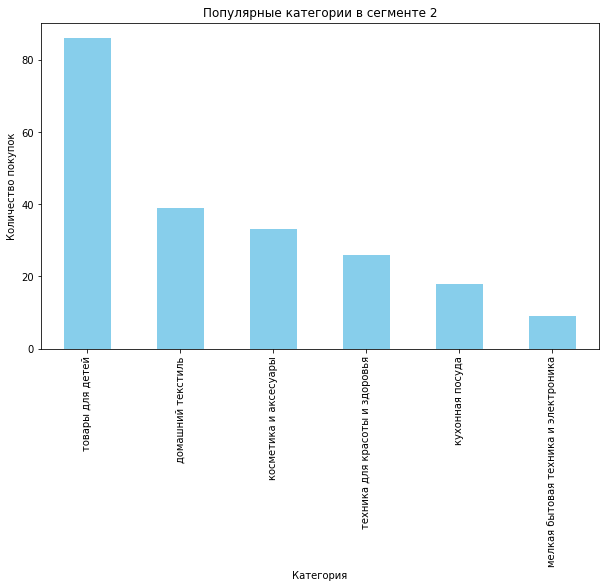

In [71]:
segment_2= market_all[market_all['segment'] == 2]

# Зависимость выручки от акционных покупок (линейный график)
plt.figure(figsize=(12, 6))
plt.plot(segment_2['акционные_покупки'], segment_2['avg_revenue'], 'o', alpha=0.5)
plt.title('Зависимость выручки от акционных покупок (Сегмент 2)')
plt.xlabel('Количество акционных покупок')
plt.ylabel('Средняя выручка')
plt.grid(True)
plt.show()

# Распределение по популярным категориям (обычный bar plot)
plt.figure(figsize=(10, 6))
segment_2['популярная_категория'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Популярные категории в сегменте 2')
plt.xlabel('Категория')
plt.ylabel('Количество покупок')
plt.show()

Сегмент 2 тоже является целевым для задачи и у него похожая картина с провалами в покупказх по акции в середине, при этом есть дисбаланс в категориях покупки в сторону товаров для детей, попробовать исправить ситуацию можно предлагая рассрочки и акционные предложения по другим категориям для увеличения времени нахождения на сайте и просмотра различных страниц

Выводы:
Из данного граффика вырочки от вероятности снижения активности можно выделить несколько категорий в зависимости от задач:
1) Категория с низкой выручкой и низкой вероятностью снижения активности(левый нижний угол) и попробовать повысить прибыль у этой категории предложив им специальные условия персональные предложения при этом по shape вероятность может подрасти однако прибыль повысится
2) категория людей с высокой прибылью и высокой вероятностью уменьшения спроса, для таких людей нужно сделать предложения из разных категорий что увеличит время их пребывания на платформе и погложительно скажется на уменьшение вероятности уменьшения активности
3) люди средней настройки в завимости от цели можно использовать один из предложенных подходов

## Общий вывод

В качестве заказчика выступает магазин интернет товаров в Один клик  укоторого падает активность покупателей, требуется на основе данных разработать решения позволяющие удержать активность постоянных клиентов. 
Для решения данной задачи было проведенно несколько стадий:
Загрузка исходных данных и предобработка:
В данных market_file содержится 1300 строк без пропусков. Типы данных соответствуют столбцам. Целесообразно проверить на дубликаты и исправить регистр.В данных market_money содержится 3900 строк без пропусков. Данные на одного пользователя представленны по месяцам.В данных market_info представленна статистика  минутой на одного пользователя за два месяца текуший и предыдущий с явной опечаткой.Датафрейм money пришлось открывать через разделитель sep=; и заменить запятую на точку в значении прибыль. В данных представленна статистика прибыли по каждому клиенту. Все датафремы связаны по id.В данных market_file отсутсвуют дубликаты и пропуски. Произвден преход к змеиному регистру в названиях столбцов и данных типа object. Исправленна опечатка в столбце тип_сервиса стандартт на стандарт в остальных столбцах все впорядке.В market_money нет пропусков, дубликатов и опечаток, только названия столбцов приведены к нижнеиу регистру. В market_time нет пропусков и дубликатор, регистр столбцов замене на нижний и испарвленна опечатка в периодне на предыдущий месяц.В данных money нет пропусков и дубликатов только регистр столбцов заменен на нижний.
Исследовательский анализ данных и обьединение таблиц в анализируемую, корреляционный анализ полученной таблицы:
market_file 1)Активность за 6 месяцев распределена со смением в прав в основном с больше 3,5 месяцев с наличием выбросов 1-2 месяца, что старанно так как длительность с момента регситрации больше 110 дней с медианой 600 или 10 месяцев. Видно что к 4 месяцу резко увеличилась актвиность интересно это акция или сезон праздников.
2) Активность за текуший месяц 3-5 
3) Длительность распределна нормально от 110 до 1089 дней 
4) Распределение акционных покупок интересное большая часть 0,15-0,35 и больше 0,85. Правое отклонение яшик с усами показывает как выбросы хотя это клиенты которые покупают только по акции, явно две категории клиентов 
5) В основном клиенты смотрят нескольок категорний 2-5
6) Число неоплаченых товаров  в корзине 1-4 что говорит о том чтотлюди добавляют в корзину то что хотят купить 
7) В среднем покупателя касается 4 сбоя сервиса а с большой вероятностью 3-6
8) За визит большая часть покупателей просматривают 5-11  страниц
9) почти у трети покупателей снизилась покупательная активность
10) колчиство покупателей с премиальным сервисом в 2,5 раза меньше чем сос тандартным
11) Три из черытрех покупателей разрешают сообщать платформе доп информацию о покупках
12) Самой покупательнйо категорией явлвяется товары для детей, домашний текстиль, косметика и аксессуары. Менее покупаемой является кохоная посуда, мелкая бытовая техника и электроника 
market_time В среднем покупатели проводят на сайте 13 минут в месяц. От 4 до 23. Текущий и предыдущий месяц представленны равномерно
market_money Средння выручка с клиента 5000 распределна номинально 2700 до 7800, с наличием выбросов которые явно надо учитывать. Впорос остался надо ли удалять пользователя без прибыли
money В среденем продавец получает выручку от одного покупателя 4000 что на 1000 меньше выручки видимо какието затраты учитывает
Клиенты с покупательнйо актитвностью в последнии 3 месяца учтены в money_new
В данном разделе был произведено обьединение треж тадблиц market_file, market_money, market_time в одну таблицу market_all. Во всех таблицах одинаковый столбец id однако разные периоды в money_time два месяца пердыдущий и текущий, в market_money три периодна предыдущий, предыдущий. Для обьединения в исходный датафрейм market_file дыли добавлены данные расчета сводных таблиц по периодам в виде отдельных столбцов минут_текущий,минут_предыдущий, выручка_препредыдущий, выручка_предыдущий, выручка_текущий. Изза удаления строк с отсутсвием выручки на этапе 3.5 появились пропуски nan которые пришлось заменить на медиану.
Сильной корреляции а также мультилоинеарности не было замечено. Есть кореляция между длительностью в мин и сраниц за визит, что логично и маркет автивностью за 6 месяцев и страниц за визит, длительностью что тоже вполне логично. Хотя по идее должна быть серьезная колинеарность между выручками,минутами, маркет_активностями в разные периодны.
Поиск лучшей модели описывающей зависимость снижения активности от остальных признаков:
Анализировлись четыре модели Логистической регресси, деревья прогноза, к ближайших соседей и опорных векторов, при этом в общей анализируемой таблице были как коллчисевтенные признаки разных масштабов так и категориальных для того чтобы сравнивать модели между собой была произведена разбивка таблицы на тренирововчную и тестовую выборки, кодировани, маштабирование подбор гиперпараметров моделей.В качестве метрики была выбрана roc_auc так она является сбалансориванной метриковй для категориального предсказания между precission и racal. В качестве метрики лучше использовать roc_auc . Лучший 0.9213 показала себя модель KNN регрессии с обработкой OnehotEncoder для категориальных признаков, RobustScaler для количественных признаков с количеством соседей 12. В качестве решения составлен один пайплан для анализа 4 моделей.
После был произведен shape анализ влияние признаков на вероятность снижения спроса:
Из Shap анализа можно сделать выводы:
1) Признаки которые имеют наибольшее влияние на целевой показаетль количество акционых покупок, страниц за визит, минут проведеных на платформе 2) Признаки которые имеют наименьшее влияние на целевой ошибка сервиса, тип сервиса,популярная категория,выручка

Последним этапом была произведена сегментация покупателей по выручке и вероятности снижения спроса 4 сегмента 0 -высокая выручка высокая вероятность, 1-высокая выручка
Сегмент 0 является самым важным в текущей задачи это люди с высокой выручкой и высокой вероятность уменьшения активности именно на них нужно ориентироваться, особенность этой категории что тут либо берут почти все товары по акции либо наооборот нет середины в таком сегменте нужно настраивать фильтры и предлагать им товары с разных категорий по акции и без чтобы увеличить время их пребывания и коллчиство просматриваемых категорий которые уменьшают риск снижения активности
Сегмент 2 тоже является целевым для задачи и у него похожая картина с провалами в покупказх по акции в середине, при этом есть дисбаланс в категориях покупки в сторону товаров для детей, попробовать исправить ситуацию можно предлагая рассрочки и акционные предложения по другим категориям для увеличения времени нахождения на сайте и просмотра различных страниц